In [1]:
import os
from ultralytics import NAS
os.chdir("..")
ROOT = os.getcwd()
print(ROOT)


/Users/mautushid/github/Cowsformer


In [5]:
from models.nas import *


The console stream is logged into /Users/mautushid/sg_logs/console.log


[2023-11-06 00:23:42] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-11-06 00:23:43] WARNING - redirects.py - NOTE: Redirects are currently not supported in Windows or MacOs.
[2023-11-06 00:23:50] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-11-06 00:23:50] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-11-06 00:23:50] WARNING - export.py - Failed to import pytorch_quantization
[2023-11-06 00:23:50] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-11-06 00:23:50] WARNING - env_sanity_check.py - Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.


In [8]:
### class inits and other inputs

path_model = 'yolo_nas_l' 
dir_train = "/Users/mautushid/github/Cowsformer/data/cow200/yolov5/train"
dir_val = "/Users/mautushid/github/Cowsformer/data/cow200/yolov5/val"
dir_test = "/Users/mautushid/github/Cowsformer/data/cow200/yolov5/test"
name_task = "cow200"

data_yaml_path = "/Users/mautushid/github/Cowsformer/data/cow200/yolov5/data.yaml"
finetuned_model_path = "/Users/mautushid/github/Cowsformer/checkpoints/n200_yolo_na_i1_trial100/ckpt_best.pth"

### Creating instance of Niche_YOLO_NAS class
my_nas = Niche_YOLO_NAS(path_model, dir_train, dir_val, dir_test, name_task)


[2023-11-06 00:25:20] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


In [9]:
### load finetuned model
best_model = my_nas.load(finetuned_model_path)

[2023-11-06 00:25:24] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/checkpoints/n200_yolo_na_i1_trial100/ckpt_best.pth EMA checkpoint.


model /Users/mautushid/github/Cowsformer/checkpoints/n200_yolo_na_i1_trial100/ckpt_best.pth loaded


In [10]:
my_nas.evaluate_trained_model(best_model, data_yaml_path, "test")

Test:   0%|          | 0/14 [00:00<?, ?it/s][W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Test: 100%|██████████| 14/14 [08:20<00:00, 28.07s/it]

{'Precision@0.50': tensor(0.8883),
 'Recall@0.50': tensor(0.9499),
 'mAP@0.50': tensor(0.9343),
 'F1@0.50': tensor(0.9180),
 'Precision@0.50:0.95': tensor(0.6955),
 'Recall@0.50:0.95': tensor(0.7437),
 'mAP@0.50:0.95': tensor(0.7102),
 'F1@0.50:0.95': tensor(0.7188)}

Test: 100%|██████████| 14/14 [08:30<00:00, 36.43s/it]


Confusion Matrix: [[        357          21]
 [         52           0]]


ConfusionMatrix(matrix=array([[        357,          21],
       [         52,           0]]), num_classes=1, conf_threshold=0.5, iou_threshold=0.5)

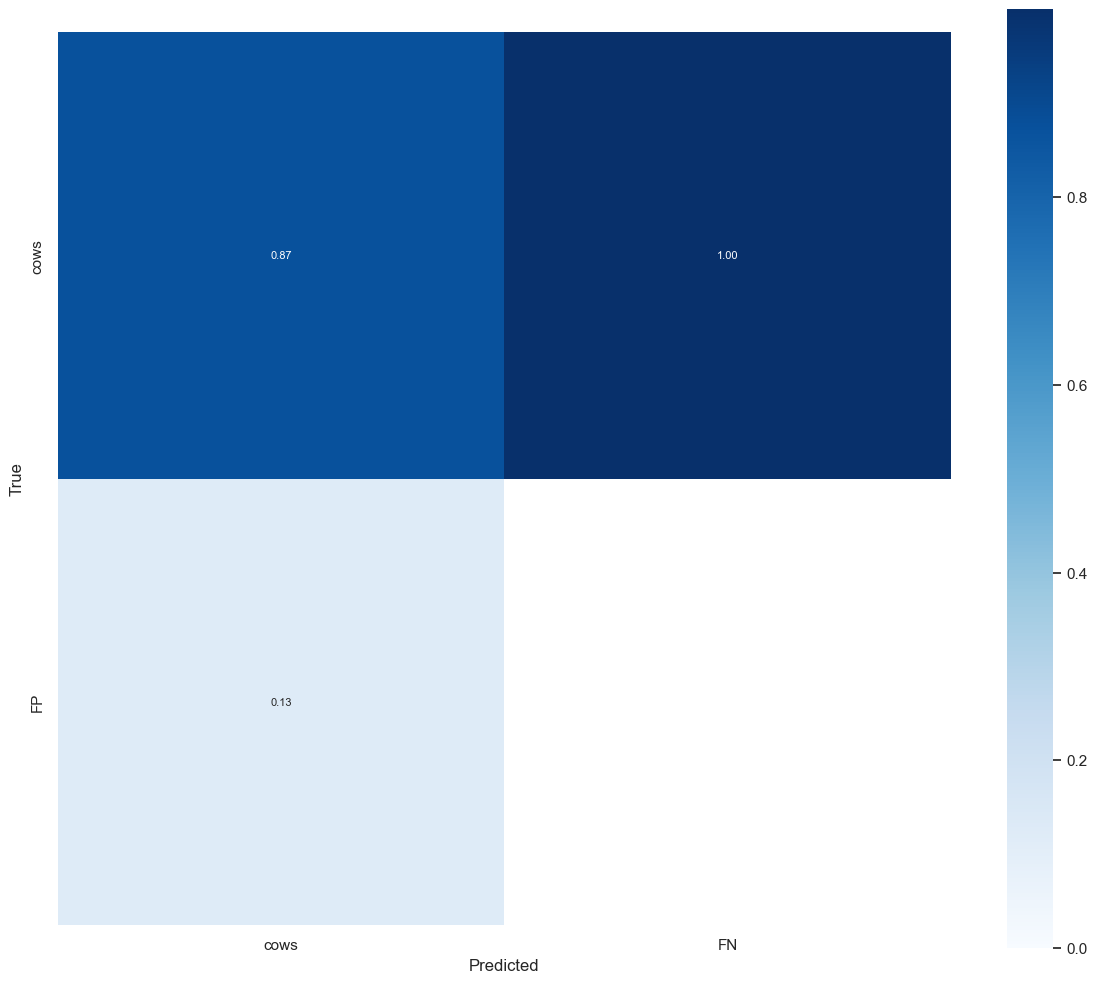

In [ ]:
my_nas.get_evaluation_matrix(best_model, data_yaml_path)